In [1]:
#importing libraries for model training
import os
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
train_dir='./Dataset/TRAIN_DIR'
test_dir='./Dataset/TEST_DIR'

In [3]:

# Initialize the ImageDataGenerator with data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    rescale=1/255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Initialize the ImageDataGenerator for testing (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size
batch_size = 32

# Create training and testing data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  
)
print(f"Class labels mapping: {train_generator.class_indices}")


Found 286 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Class labels mapping: {'mild': 0, 'severe': 1}


## Applying Data Augmentation to increase Data Size

In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Paths to the folders
train_dir = './Dataset/TRAIN_DIR'
output_dir = './augmented_train/'

# Initialize ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Augment and save images for each class
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    output_class_path = os.path.join(output_dir, class_name)

    if not os.path.exists(output_class_path):
        os.makedirs(output_class_path)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)  # Load image
        img_array = img_to_array(img)  # Convert to array
        img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for augmentation

        # Generate augmented images
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_class_path,
                                  save_prefix=img_name.split('.')[0], save_format='png'):
            i += 1
            if i >= 5:  # Save 5 augmented versions
                break

print(f"Augmented images saved to: {output_dir}")


Augmented images saved to: ./augmented_train/


In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Paths to the folders
train_dir = './Dataset/TEST_DIR'
output_dir = './augmented_test/'

# Initialize ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Augment and save images for each class
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    output_class_path = os.path.join(output_dir, class_name)

    if not os.path.exists(output_class_path):
        os.makedirs(output_class_path)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)  # Load image
        img_array = img_to_array(img)  # Convert to array
        img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for augmentation

        # Generate augmented images
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_class_path,
                                  save_prefix=img_name.split('.')[0], save_format='png'):
            i += 1
            if i >= 5:  # Save 5 augmented versions
                break

print(f"Augmented images saved to: {output_dir}")


Augmented images saved to: ./augmented_test/


In [6]:
train_dir='./augmented_train/'
test_dir='./augmented_test/'
# Create training and testing data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  
)
print(f"Class labels mapping: {train_generator.class_indices}")


Found 1430 images belonging to 2 classes.
Found 490 images belonging to 2 classes.
Class labels mapping: {'mild': 0, 'severe': 1}


In [8]:
# Input shape since VGG16 is used
input_shape = (224, 224, 3)

# Load the base model
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model for the classification task of cataract images
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with an initial learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 77s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,503,489 (211.73 MB)

 Trainable params: 12,845,313 (49.00 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [9]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnetmodel.keras', monitor='val_loss', save_best_only=True)

# Train the model with frozen base layers
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)



/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.6241 - loss: 2.6327 - val_accuracy: 0.8959 - val_loss: 0.7496
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8658 - loss: 0.6140 - val_accuracy: 0.9163 - val_loss: 0.4003
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8838 - loss: 0.4038 - val_accuracy: 0.9122 - val_loss: 0.3711
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8791 - loss: 0.3962 - val_accuracy: 0.7776 - val_loss: 0.5277
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1666s 38s/step - accuracy: 0.8683 - loss: 0.3930 - val_accuracy: 0.9245 - val_loss: 0.3271
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8866 - loss: 0.3684 - val_accuracy: 0.9245 - val_loss: 0.3366
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9099 - loss: 0.3361 - val_accuracy: 0.9245 - val_loss: 0.3029
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8896 - loss: 0.3597 - val_accuracy: 0.9306 - val

In [10]:
# Load the best model from training
model.load_weights('resnetmodel.keras')

# Fine-tune the model: Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Train model on the data again to finetune last few layers
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuned layers
history_fine_tuning = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)



Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.9009 - loss: 0.3562 - val_accuracy: 0.8980 - val_loss: 0.3378
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8944 - loss: 0.3331 - val_accuracy: 0.7000 - val_loss: 0.5635
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9087 - loss: 0.2918 - val_accuracy: 0.6878 - val_loss: 0.5595
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.8908 - loss: 0.3166 - val_accuracy: 0.5939 - val_loss: 0.6997
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.9110 - loss: 0.2876 - val_accuracy: 0.4878 - val_loss: 1.0088
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.8878 - loss: 0.3200 - val_accuracy: 0.6653 - val_loss: 0.6436


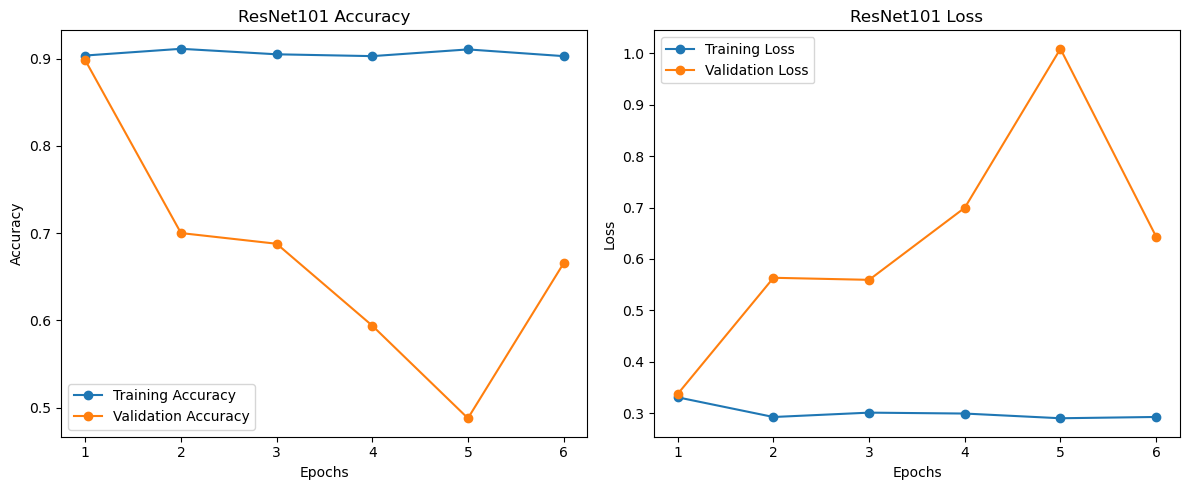

In [11]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history, title_prefix="Model"):
    """
    Plots the training and validation loss and accuracy.

    Parameters:
        history: The history object from model training.
        title_prefix: Prefix for the plot titles.
    """
    # Get training and validation metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for VGG16 model
plot_loss_accuracy(history_fine_tuning, title_prefix="ResNet101")



In [12]:
# Save the final model (architecture + weights) in .keras format
final_model_dir = os.path.join('..', 'Phase2') 
if not os.path.exists(final_model_dir):
    os.makedirs(final_model_dir)  

final_model_path = os.path.join(final_model_dir, 'renet_model.keras')
model.save(final_model_path)

In [13]:
model.evaluate(test_generator, steps=len(test_generator))

16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.8893 - loss: 0.3975


[0.3377501368522644, 0.8979591727256775]

16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step


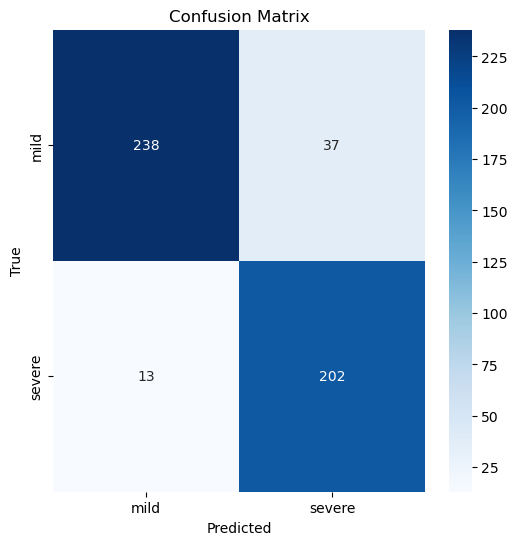

Classification Report:
              precision    recall  f1-score   support

        mild       0.95      0.87      0.90       275
      severe       0.85      0.94      0.89       215

    accuracy                           0.90       490
   macro avg       0.90      0.90      0.90       490
weighted avg       0.90      0.90      0.90       490



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predicting the labels for the test dataset
test_generator.reset()  
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary (0 or 1) based on threshold of 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Get the true labels from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_predict_image(image_path, target_size=(224, 224)):
    
    # Load the image from the given path
    img = image.load_img(image_path, target_size=target_size)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()

    # Preprocess the image to match model input requirements
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0 
    
    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = (predictions > 0.5).astype(int)
    print(f"Predicted class: {'Severe' if predicted_class[0][0] == 1 else 'Mild'}")
    return predicted_class[0][0]


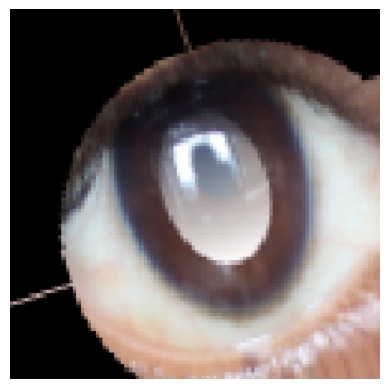

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Predicted class: Severe


1

In [19]:
image_path = 'augmented_test/severe/severe_124_0_1530.png'
load_and_predict_image(image_path)

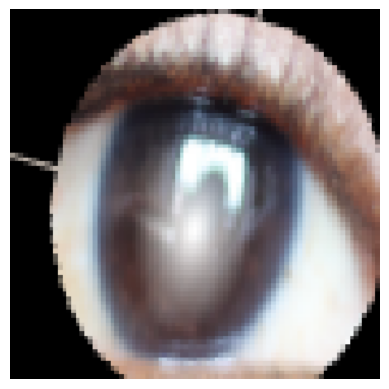

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Predicted class: Mild


0

In [21]:
image_path = 'augmented_test/mild/mild_167_0_19.png'
load_and_predict_image(image_path)

## MobileNetV2 Model

In [22]:
# Input shape since VGG16 is used
input_shape = (224, 224, 3)

# Load the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model for the classification task of cataract images
mobilenetmodel = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model with an initial learning rate
mobilenetmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
mobilenetmodel.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,286,401 (39.24 MB)

 Trainable params: 8,028,417 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('mobilenetmodel.keras', monitor='val_loss', save_best_only=True)

# Train the model with frozen base layers
history1 = mobilenetmodel.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 339ms/step - accuracy: 0.8568 - loss: 2.7876 - val_accuracy: 0.9245 - val_loss: 1.9635
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 307ms/step - accuracy: 0.9722 - loss: 1.7122 - val_accuracy: 0.9367 - val_loss: 1.6405
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.9607 - loss: 1.4531 - val_accuracy: 0.9571 - val_loss: 1.4247
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.9473 - loss: 1.3269 - val_accuracy: 0.9408 - val_loss: 1.3335
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 296ms/step - accuracy: 0.9699 - loss: 1.1653 - val_accuracy: 0.9184 - val_loss: 1.3560
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 303ms/step - accuracy: 0.9767 - loss: 1.0551 - val_accuracy: 0.9469 - val_loss: 1.1836
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.9781 - loss: 0.9591 - val_accuracy: 0.9122 - val_loss: 1.2151
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 304ms/step - accuracy: 0.9778 - loss: 0.9186 - val_accu

In [24]:
# Load the best model from training
mobilenetmodel.load_weights('mobilenetmodel.keras')

# Fine-tune the model: Unfreeze the last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Train model on the data again to finetune last few layers
mobilenetmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training with fine-tuned layers
history_fine_tuning1 = mobilenetmodel.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 336ms/step - accuracy: 0.9755 - loss: 0.4011 - val_accuracy: 0.9633 - val_loss: 0.4091
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 0.9823 - loss: 0.2465 - val_accuracy: 0.9449 - val_loss: 0.3581
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 343ms/step - accuracy: 0.9827 - loss: 0.2317 - val_accuracy: 0.9571 - val_loss: 0.3447
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - accuracy: 0.9881 - loss: 0.2260 - val_accuracy: 0.9612 - val_loss: 0.4091
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step - accuracy: 0.9908 - loss: 0.2131 - val_accuracy: 0.9000 - val_loss: 0.3894
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step - accuracy: 0.9899 - loss: 0.1961 - val_accuracy: 0.9714 - val_loss: 0.3009
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - accuracy: 0.9901 - loss: 0.1967 - val_accuracy: 0.9755 - val_loss: 0.2677
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 364ms/step - accuracy: 0.9863 - loss: 0.1967 - val_accu

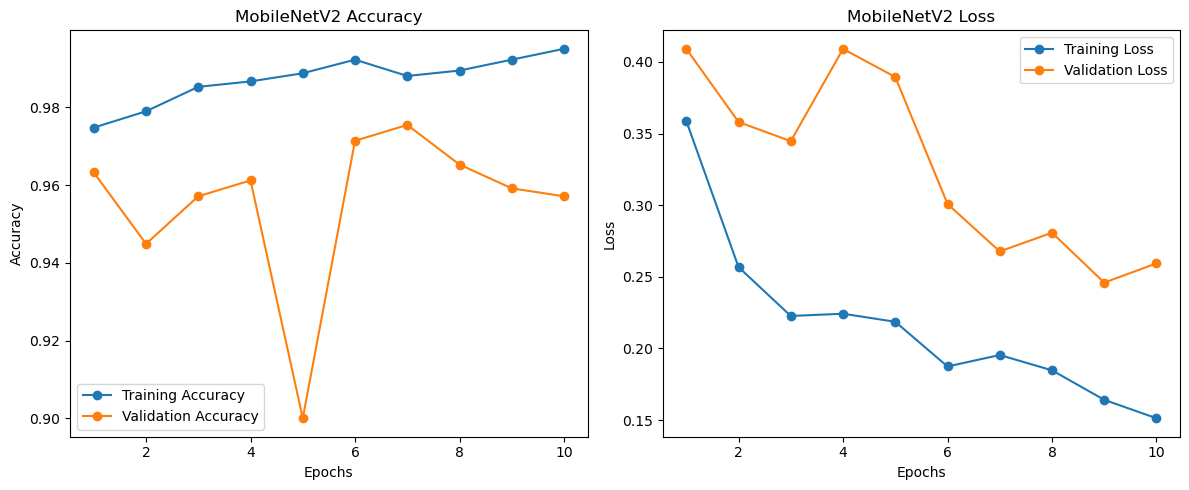

In [25]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history, title_prefix="Model"):
    """
    Plots the training and validation loss and accuracy.

    Parameters:
        history: The history object from model training.
        title_prefix: Prefix for the plot titles.
    """
    # Get training and validation metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Plot for InceptionV3 model
plot_loss_accuracy(history_fine_tuning1, title_prefix="MobileNetV2")


In [26]:
# Save the final model (architecture + weights) in .keras format
final_model_dir = os.path.join('..', 'Phase2') 
if not os.path.exists(final_model_dir):
    os.makedirs(final_model_dir)  

final_model_path = os.path.join(final_model_dir, 'mobilenet_model.keras')
model.save(final_model_path)

In [27]:
mobilenetmodel.evaluate(test_generator, steps=len(test_generator))

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.9449 - loss: 0.2768


[0.24595077335834503, 0.9591836929321289]

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step


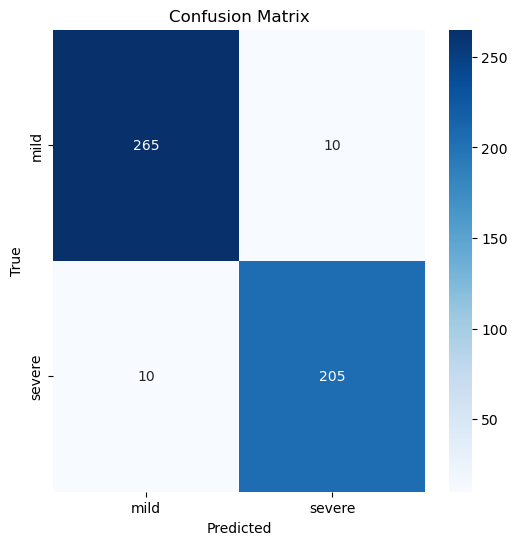

Classification Report:
              precision    recall  f1-score   support

        mild       0.96      0.96      0.96       275
      severe       0.95      0.95      0.95       215

    accuracy                           0.96       490
   macro avg       0.96      0.96      0.96       490
weighted avg       0.96      0.96      0.96       490



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predicting the labels for the test dataset
test_generator.reset()  # To reset the generator for evaluation
predictions = mobilenetmodel.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary (0 or 1) based on threshold of 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Get the true labels from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_predict_image(image_path, target_size=(224, 224)):
    
    # Load the image from the given path
    img = image.load_img(image_path, target_size=target_size)
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()

    # Preprocess the image to match model input requirements
    img_array = image.img_to_array(img) 
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0 
    
    # Predict the class
    predictions = mobilenetmodel.predict(img_array)
    predicted_class = (predictions > 0.5).astype(int)
    print(f"Predicted class: {'Severe' if predicted_class[0][0] == 1 else 'Mild'}")
    return predicted_class[0][0]


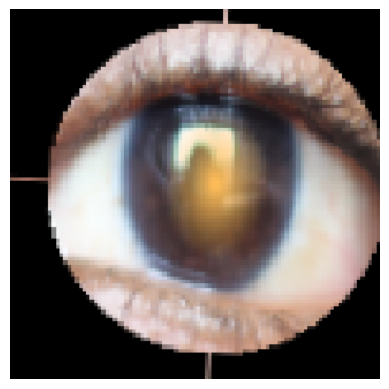

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
Predicted class: Mild


0

In [31]:
image_path = 'augmented_test/mild/mild_166_0_4521.png'
load_and_predict_image(image_path)

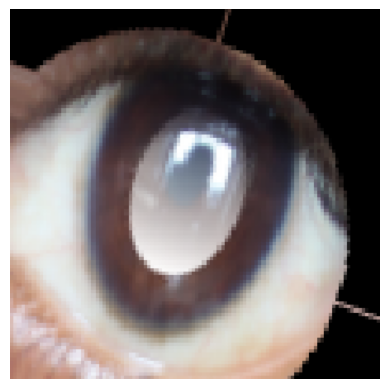

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: Severe


1

In [32]:
image_path = 'augmented_test/severe/severe_124_0_8196.png'
load_and_predict_image(image_path)

In [33]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to compute metrics for each model
def get_classification_metrics(model, test_generator):
    true_labels = test_generator.classes
    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
    predicted_labels = (predictions > 0.5).astype(int)

    # Compute classification metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return accuracy, precision, recall, f1

# Get the metrics for Resnet101 model
renset101_metrics = get_classification_metrics(model, test_generator)

# Get the metrics for MobilenetV2 model
mobilenetv2_metrics = get_classification_metrics(mobilenetmodel, test_generator)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Model': ['ResNet101', 'MobileNetV2'],
    'Accuracy': [renset101_metrics[0], mobilenetv2_metrics[0]],
    'Precision': [renset101_metrics[1], mobilenetv2_metrics[1]],
    'Recall': [renset101_metrics[2], mobilenetv2_metrics[2]],
    'F1-Score': [renset101_metrics[3], mobilenetv2_metrics[3]]
})

# Display the metrics
print(metrics_df)


16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step
         Model  Accuracy  Precision    Recall  F1-Score
0    ResNet101  0.897959   0.845188  0.939535  0.889868
1  MobileNetV2  0.959184   0.953488  0.953488  0.953488


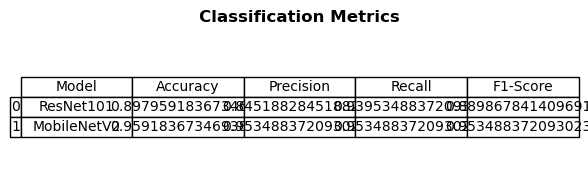

In [34]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Visualize the metrics table
def visualize_metrics_table(metrics_df):
    fig, ax = plt.subplots(figsize=(6, 2))  # Adjust figure size as needed
    ax.axis('off')  # Turn off the axis
    ax.axis('tight')  # Fit the table within the axes
    tbl = table(ax, metrics_df, loc='center', cellLoc='center')  # Create the table
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)  # Set the font size of the table
    tbl.scale(1.2, 1.2)  # Scale the table (adjust as needed for better fit)
    plt.title("Classification Metrics", fontsize=12, weight='bold')
    plt.show()

# Visualize the DataFrame
visualize_metrics_table(metrics_df)
